# Vehicle Detection Project

## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don’t forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## 0. Import dependencys

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import random

%matplotlib inline

## 1. Trainingdata

In [2]:
car_images = glob.glob('training_data/vehicles/**/*.png')
non_car_images = glob.glob('training_data/non-vehicles/**/*.png')
                       
num_of_cars = len(car_images);
num_of_non_cars = len(non_car_images)

print('Number of car images ' + str(num_of_cars))
print('Number of non car images ' + str(num_of_non_cars))

Number of car images 8792
Number of non car images 8968


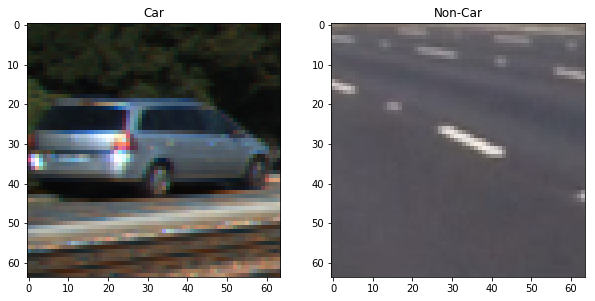

In [3]:
car_id = random.randint(1, num_of_cars) 
non_cars_id = random.randint(1, num_of_non_cars) 

car = plt.imread(car_images[car_id])
non_car = plt.imread(non_car_images[non_cars_id])

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(car)
plt.title('Car')

plt.subplot(1,2,2)
plt.imshow(non_car)
plt.title('Non-Car')

## 2. Feature extrection

### 1. HOG features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

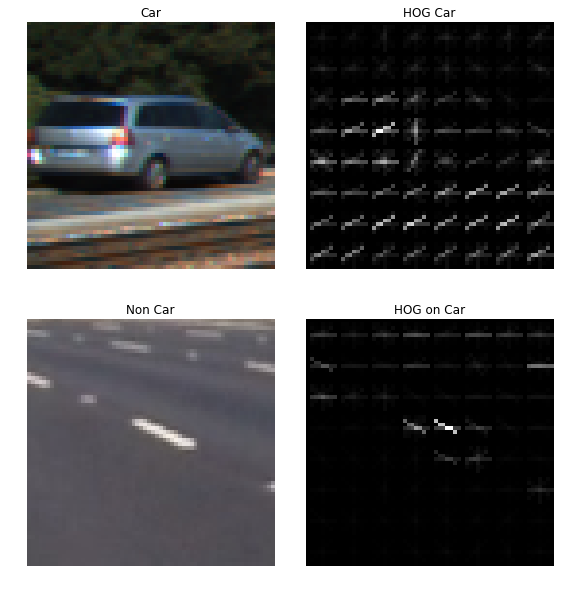

In [5]:
car_features, car_hog = get_hog_features(car[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
non_car_features, non_car_hog = get_hog_features(non_car[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

fig, axs = plt.subplots(2,2, figsize=(10,10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Car')
axs[0].imshow(car)

axs[1].axis('off')
axs[1].set_title('HOG Car')
axs[1].imshow(car_hog, cmap='gray')

axs[2].axis('off')
axs[2].set_title('Non Car')
axs[2].imshow(non_car)

axs[3].axis('off')
axs[3].set_title('HOG on Car')
axs[3].imshow(non_car_hog, cmap='gray')



### 4. Extract Features

In [6]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [7]:
#orient = 11
#pix_per_cell = 16
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

print('Start feature extraction ...' )
t=time.time()

car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

not_car_features = extract_features(non_car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2=time.time()

print('Feature extraction needed ' + str(round(t2-t, 2)) + ' secs'  )

# Create an array stack of feature vectors
X = np.vstack((car_features, not_car_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

Start feature extraction ...
Feature extraction needed 123.49 secs


## 3. Training

### 1. Split Traindata  into Train and Testsdata

In [8]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 5292


### 2. Training a LinearSVC

In [9]:
# Use a linear SVC 
svc = LinearSVC()
print('Start training')
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

Start training
7.16 Seconds to train SVC...


### 3. Accuracy and predictions

In [10]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9834
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  0.  0.  0.  0.]
0.00472 Seconds to predict 10 labels with SVC


In [11]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [12]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

19 rectangles found in image


In [13]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


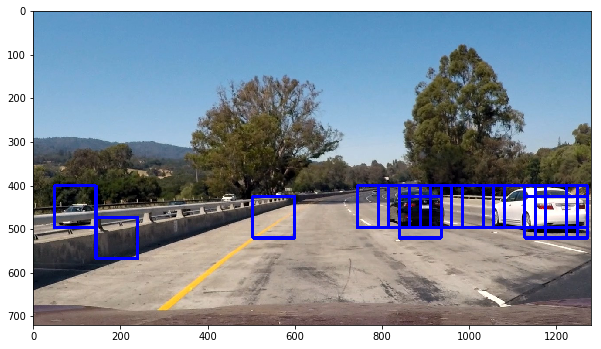

In [14]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

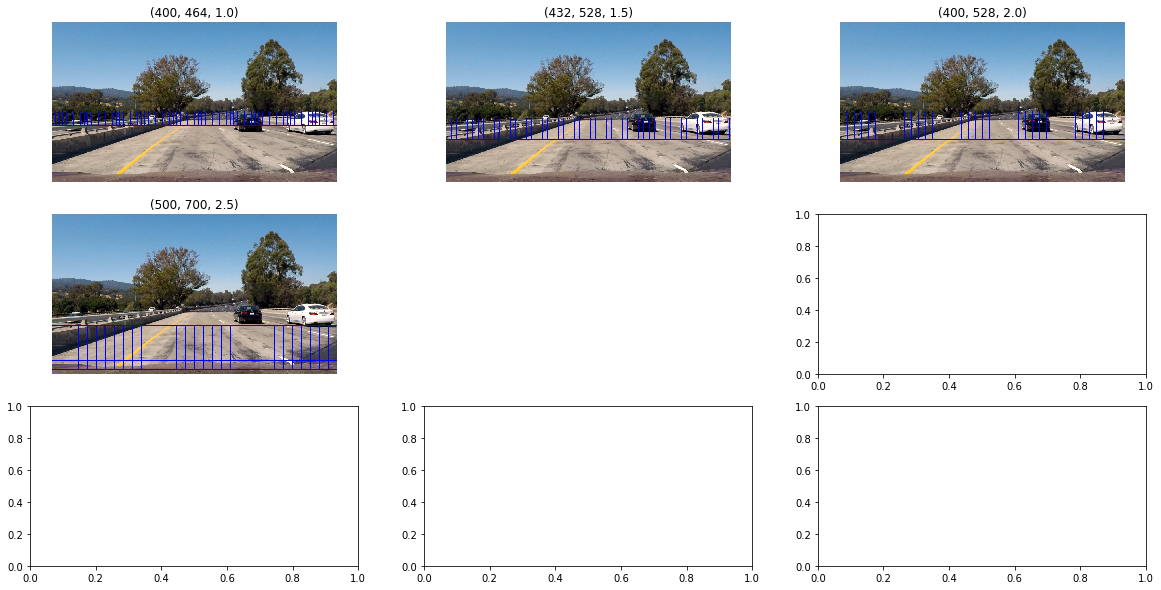

In [15]:
test_img = mpimg.imread('./test_images/test1.jpg')

search_area = [
    #(380, 480, 1.0),
    (400, 464, 1.0),
    #(416, 480, 1.0),
    #(400, 600, 1.5),
    #(400, 496, 1.5),
    (432, 528, 1.5),
    (400, 528, 2.0),
    #(432, 560, 2.0),
    (500, 700, 2.5),
    #(400, 596, 3.5),
    #(464, 660, 3.5)
    ]


rects = []

for (ystart, ystop, scale) in search_area:
    rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

cols = 3
rows = 2
fig, axs = plt.subplots(rows, cols, figsize=(20,10))
axs = axs.ravel()

i = 0
for sublist in rects:
    test_img_rects = draw_boxes(test_img, sublist, thick=2)
    axs[i].axis('off')
    axs[i].set_title(str(search_area[i]))
    axs[i].imshow(test_img_rects)
    i = i + 1
    
if i < cols * rows:
    axs[i].axis('off')
    i = i + 1   

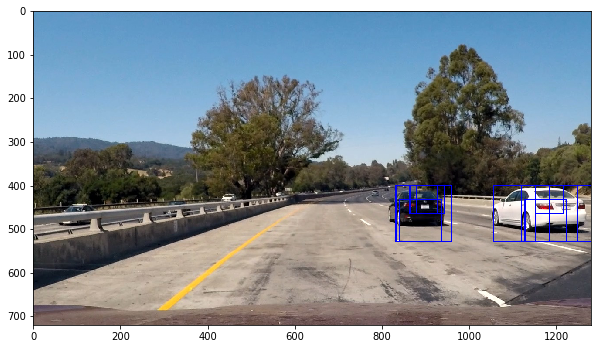

In [16]:
rects = []

for (ystart, ystop, scale) in search_area:
    rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Heatmap

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

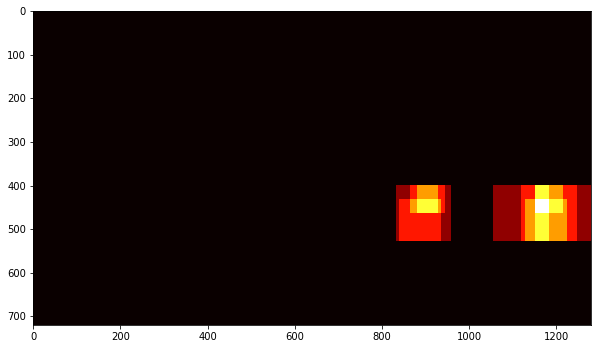

In [18]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

In [19]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

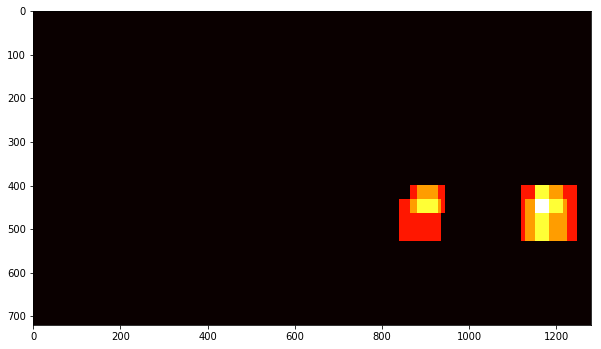

In [20]:
hits = 1
heatmap_img = apply_threshold(heatmap_img, hits)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


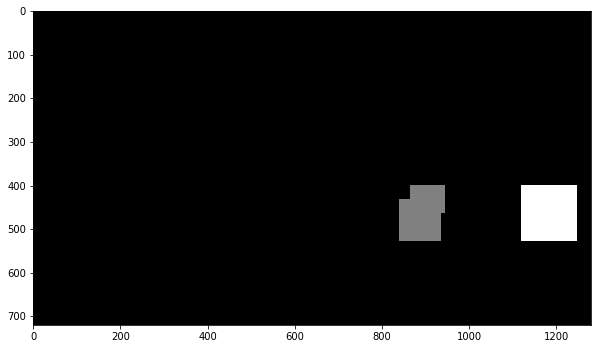

In [21]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

In [22]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

In [23]:
def process(test_img):
    loca_rects = []
    for (ystart, ystop, scale) in search_area:
        loca_rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

    rectangles = [item for sublist in loca_rects for item in sublist] 
       
    h_img = np.zeros_like(test_img[:,:,0])
    h_img = add_heat(h_img, rectangles)
     
    thred_heatmap_img = apply_threshold(h_img, hits)
        
    labels = label(thred_heatmap_img)
        
    draw_img, rects = draw_labeled_bboxes(test_img, labels)
    return draw_img

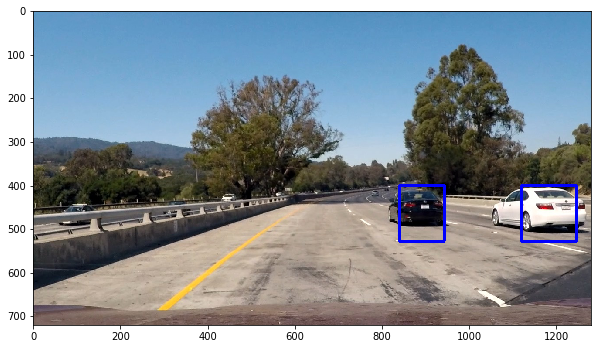

In [24]:
# Draw bounding boxes on a copy of the image
draw_img = process(test_img)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

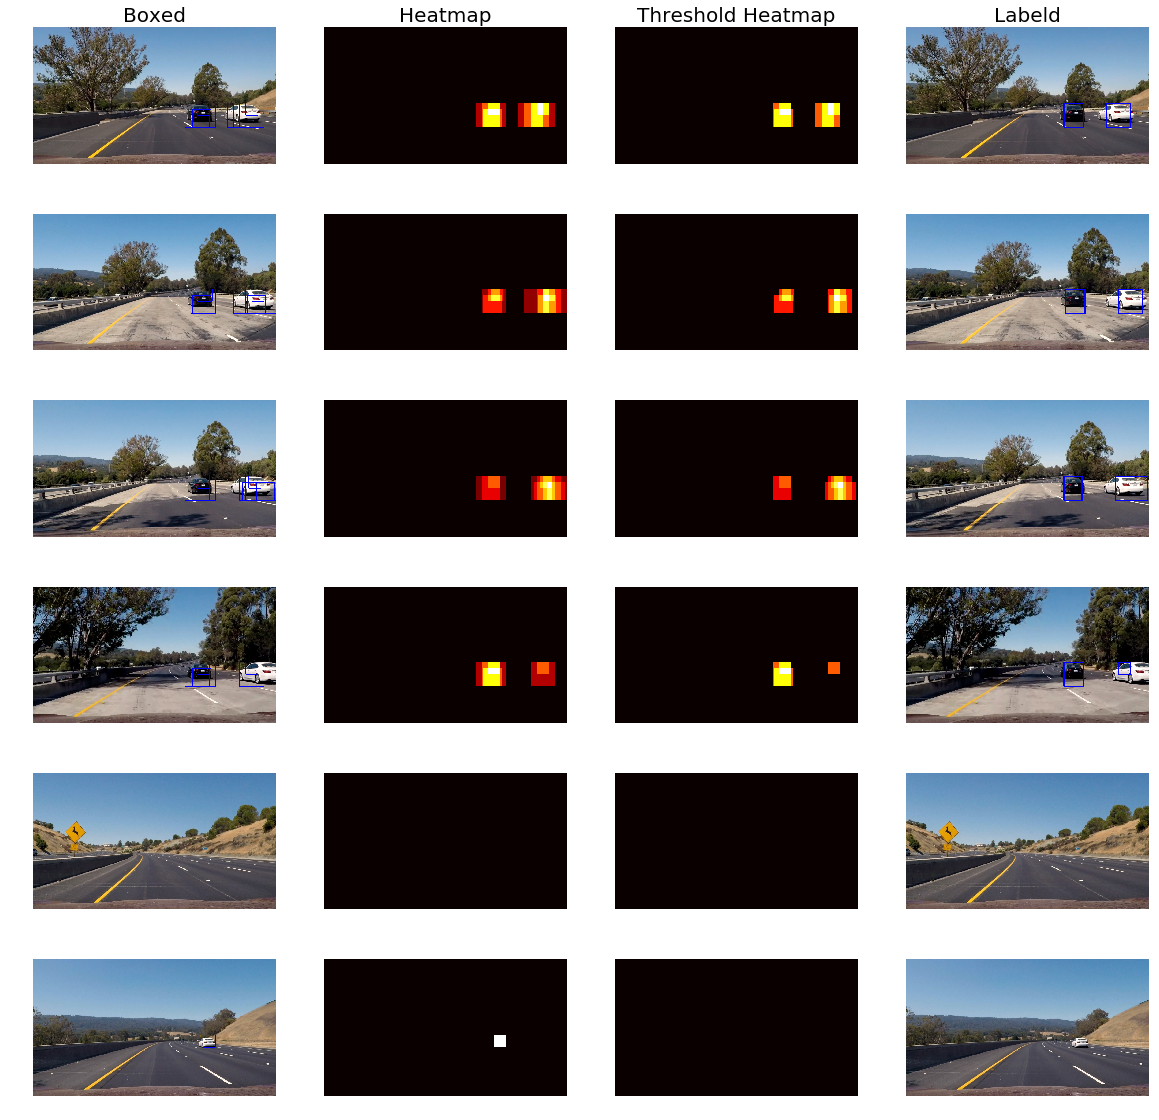

In [25]:
images = glob.glob('./test_images/*.jpg')
i = 0
COLUMNS_HEADER = ['Boxed', 'Heatmap', 'Threshold Heatmap', 'Labeld']
f, axs = plt.subplots(len(images), len(COLUMNS_HEADER), figsize=(20,20))
axs = axs.ravel()

for image in images:
    rects = []
    
    test_img = mpimg.imread(image)

    for (ystart, ystop, scale) in search_area:
        rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

    rectangles = [item for sublist in rects for item in sublist] 
    test_img_rects = draw_boxes(test_img, rectangles, thick=2)
        
    h_img = np.zeros_like(test_img[:,:,0])
    h_img = add_heat(h_img, rectangles)
    heatmap_img = np.copy(h_img) 
     
    thred_heatmap_img = apply_threshold(h_img, hits)
        
    labels_img = label(thred_heatmap_img)
        
    draw_img = process(test_img)
        
        
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(test_img_rects)
    axs[i].axis('off')
    i += 1
    
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(heatmap_img, cmap='hot')
    axs[i].axis('off')
    i += 1
            
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(thred_heatmap_img, cmap='hot')
    axs[i].axis('off')
    i += 1
    
    if(i < len(COLUMNS_HEADER)):
        axs[i].set_title(COLUMNS_HEADER[i % len(COLUMNS_HEADER)], fontsize=20)
    axs[i].imshow(draw_img)
    axs[i].axis('off')
    i += 1
                

In [26]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:15<00:00,  2.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 19.1 s, sys: 128 ms, total: 19.2 s
Wall time: 16.9 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [28]:
out_file = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
clip_out = clip.fl_image(process)
%time clip_out.write_videofile(out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [08:31<00:00,  2.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 10min 27s, sys: 2.96 s, total: 10min 30s
Wall time: 8min 32s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_file))